In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
import vBaseFunctions3 as vbf
import mcFunc as mc

sr = 1250 #Hz sampling rate 

b = '/Dupret_Lab/merged/mcastelli_merged/mvl33-221109/mvl33-221109'
resDir = '/data'
stages = vbf.LoadStages(b)
stages
si = 2
bs = b+'_'+str(si+1)

lfps = mc.lfp2mV*vbf.loadlfps(bs)

In [76]:
resDir = '/Dupret_Lab/analysis/mcastelli_analysis/dSpikesClassifier/Data/'

sdur_max_s =  30*60# 30 minutes
sdur_max_eeg = int(sdur_max_s*sr)

# cut window of lfp 
recday_s = bs.split('/')[-1]
mc.save(resDir+recday_s+'.lfp',lfps[:,:sdur_max_eeg])

In [99]:
mc.save(resDir+'mvl33-221109'+'.channels.layers',layers)

In [100]:
trodes = vbf.LoadTrodes(b)
mc.save(resDir+'mvl33-221109'+'.channels', trodes)

## Load Data for git 

In [82]:
resDir = '/Dupret_Lab/analysis/mcastelli_analysis/dSpikesClassifier/Data/'

lfp_fname = resDir+'mvl33-221109_3.lfp'
lfps = np.load(lfp_fname,allow_pickle=True,mmap_mode='r')

In [101]:
# Load Layers of Channels 
trodes = np.load(resDir+'mvl33-221109.channels',allow_pickle=True)
layers = np.load(resDir+'mvl33-221109.channels.layers',allow_pickle=True)
layers 

{'or': 11,
 'pyr': 18,
 'rad': 26,
 'lm': 33,
 'hf': 36,
 'om': 39,
 'mm': array([40, 41, 42, 43, 44, 45]),
 'im': 46,
 'gr': 51}

### Show example of lfp window

In [84]:
dg_chi = layers['gr'] # granule cell layer channel idx.
lfp_dg = lfps[dg_chi] # lfp of DG

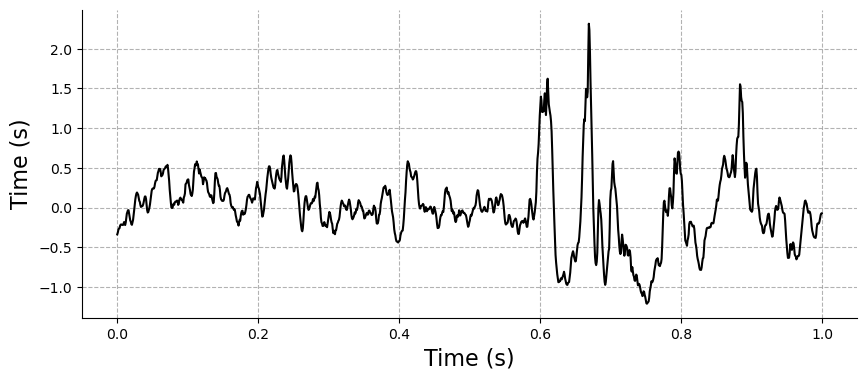

In [85]:
# Plot LFP window
t = np.arange(0,sr) # 1 sec of data
t_sec = t/sr

lfp_win = lfp_dg[t]
plt.figure(figsize=(10,4))
plt.plot(t_sec,lfp_win,color='k',lw=1.5)
plt.xlabel('Time (s)',fontsize=16)
plt.ylabel('Time (s)',fontsize=16)

mc.AdjustBoxPlot()

## Run DSpikes Prediction or Load them 

In [86]:
def detectDSpikes(lfps,ch,refch=0,mininumDelay = int(50*1.25)):
    '''
    Detect DSpikes and their profile
    Returns dSpikes, lfp_ds,profile_ds

    INPUTS:
    lfp: lfp signal (sampling rate = 1250 Hz)
    ch: channel idx for dspikes detection (DG)
    refch: channel idx. to be set as reference from ch for detection 
    mininumDelay: minimum time lag between consecutive dspikes in samples

    OUTPUTS:
    DSpikes: times correponding to DSspikes occurence in samples
    '''
    from peakdetect import detect_peaks

    lfp_c = np.array([])
    # Subtract Referenc LFP from DG Channel
    lfp0 = lfps[ch,:]-lfps[refch,:]
    # Low Pass LFP with cut-off 200 Hz
    lfp_ = vbf.bandpass(lfp0,lowf=1,hif=200)
    lfp_c = np.concatenate((lfp_c,lfp_))
    # Set threshold for detection 
    thrs = np.median(np.abs(lfp_c))*7

    dspikes = detect_peaks(lfp_,mph=thrs,mpd=mininumDelay)
    return dspikes

In [150]:
def runDSpikes_detection(lfps,dg_chi=-1):
    '''
    Detect DSpikes and their profile
    Returns dSpikes, lfp_ds,profile_ds
    
    INPUTS:
    lfp: lfp signal from gr. cell layer in DG (sampling rate = 1250 Hz)
    dg_chi: channel in DG to be used to dentate spikes detection

    OUTPUTS:
    DSpikes: eeg times corresponding to DSspikes
    '''

    ## DETECT DSpikes
    return detectDSpikes(lfps,dg_chi,refch=0)

In [88]:
dspikes = runDSpikes_detection(lfps,dg_chi=dg_chi)

sdur_s = lfps.shape[1]/sr # session duration in seconds
print(f'\n\nDetected {len(dspikes)} dentate spikes.')
print('  Avg. rate of dentate spikes {} events/sec'.format(np.round(len(dspikes)/sdur_s,2)))

      detecting DSpikes - 2023-10-20 16:01:09


Detected 360 dentate spikes.
  Avg. rate of dentate spikes 0.2 events/sec


In [89]:
## Trigger LFP in all regions with spikes times 
win_trigger_ms = 400
win_trigger_samples = int((win_trigger_ms/1000)*sr)

lfp_dspikes,taxis = vbf.triggeredAverage(lfps,dspikes,taLen=win_trigger_samples,average=False)

print(lfp_dspikes.shape)
print('(# dspikes, # channels, # time samples)')

(360, 64, 500)
(# dspikes, # channels, # time samples)


Text(0.5, 0, 'Time from dentate spike (ms)')

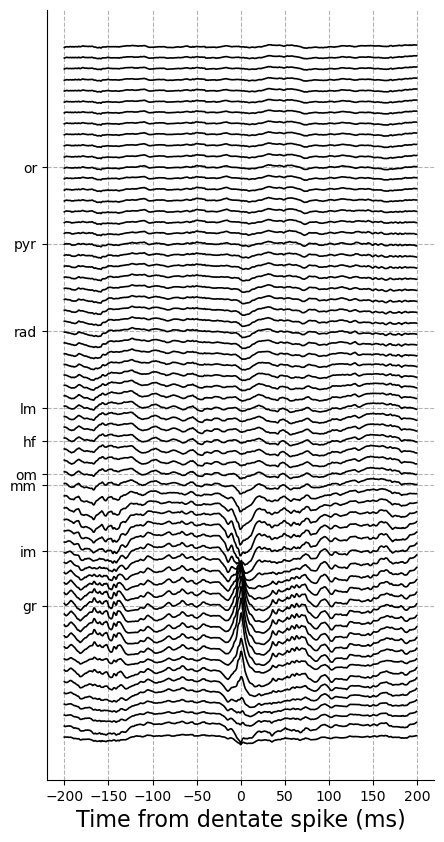

In [166]:
examplei = 0
nChs = lfp_dspikes.shape[1]

plt.figure(figsize=(5,10))
for chi,lfp_ in enumerate(lfp_dspikes[examplei]):
    plt.plot(taxis,-lfp_+chi,color='k',lw=1.2)
    
mc.probe_yticks(layers)
mc.AdjustBoxPlot()
plt.gca().invert_yaxis()
plt.xlabel('Time from dentate spike (ms)',fontsize=16)

## Run Model for DS1 and DS2 classification

In [96]:
import DSpikes.dspikes as dSpikesClassifier

/home/MRC.OX.AC.UK/trin3692/miniconda3/envs/py10/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/MRC.OX.AC.UK/trin3692/miniconda3/envs/py10/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearDiscriminantAnalysis from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/MRC.OX.AC.UK/trin3692/miniconda3/envs/py10/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.

In [98]:
dSpikesClassifier.model_report()

#### REPORT ON TRAINED MODEL ####
########################
DATASET DESCRIPTION:
	-n. recdays = 9
	-n. mice = 3

Dataset contained 15085 dentate spikes which were used to trained the model.

    The model reached an accuracy of 85.25% (k=20 cross validation, chance level: 50%).


### Classification by giving the lfps of all channels and the times of dspikes

############################
Classification report:
Total # spikes:  360
 44.44 % of  DS1
 55.56 % of  DS2


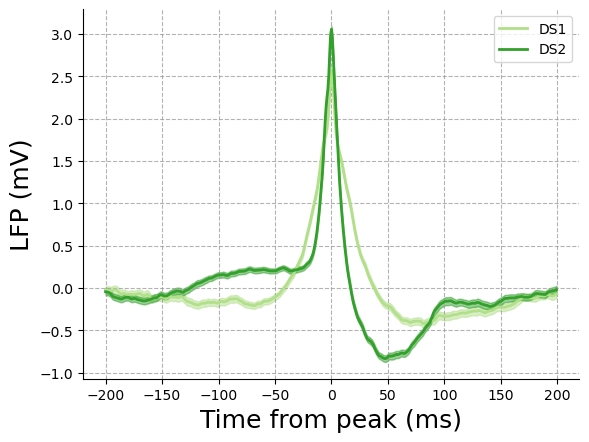

In [151]:
## The model will 
# 1) trigger the lfps in the GR with the dspikes timestamps
# 2) Choose the channel in dg which best matches the DS template used to train of model
# 3) Pre-Process LFP in selected channel for DS class prediction
# 4) Predict the Class of DS spikes (i.e. DS1 or DS2 for each event)

###### OUTPUTS #########################################################
#     DSclass_pred: DSspike class prediction  0s and 1s -> ds1,ds2
#     lfp_ds_GR: is the lfp in the DG reference channel triggered for all DSpikes
#     dspikes: DSpikes timestamps corresponding to the class 
#              (in case triggering window exceds lfp duration)

DSclass_pred,lfp_ds_GR,dspikes_c = dSpikesClassifier.predictDS_class(lfps,dspikes=dspikes\
                                                 ,GRchi=None,trodes=trodes,plot=True,report=True)

############################
Classification report:
Total # spikes:  360
 42.78 % of  DS1
 57.22 % of  DS2


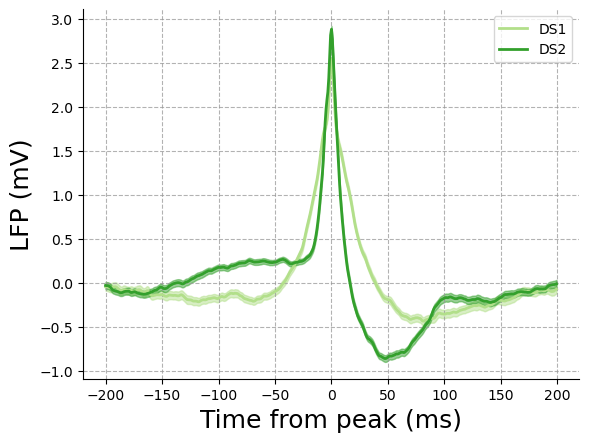

In [152]:
## Or you can manually hoose the channel used for DS class prediction 
# By setting GRchi to a integer; this allows more robust 
chi = layers['gr'] # select DG channel for model 
DSclass_pred,lfp_ds_GR,dspikes_c = dSpikesClassifier.predictDS_class(lfps,dspikes=dspikes,\
                                                 GRchi=chi,trodes=None,plot=True,report=True)

(360, 64, 500)  - (# spikes, # channels, # num samples (eeg))
############################
Classification report:
Total # spikes:  360
 42.78 % of  DS1
 57.22 % of  DS2


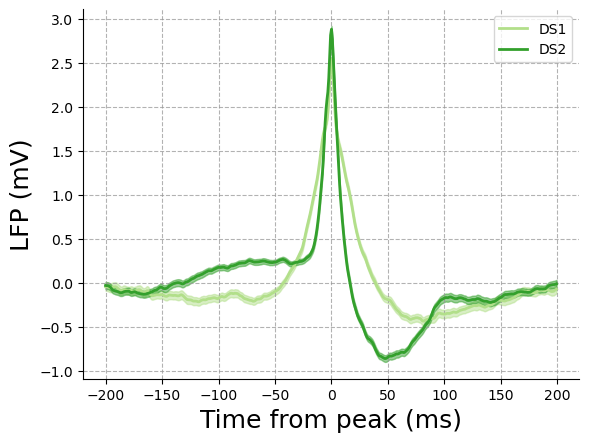

In [153]:
## You can also trigger the LFP before and give the dspikes-triggered LFP to the model

# Trigger LFPs in all channels with DSPikes times
lfp_ds = dSpikesClassifier.triggerLFP(lfps,dspikes)
print(lfp_ds.shape,' - (# spikes, # channels, # num samples (eeg))')
chi = layers['gr'] # select reference DG channel for classification

DSclass_pred,lfp_ds_GR,dspikes_c = dSpikesClassifier.predictDS_class(lfp_ds,GRchi=chi,
                                                       trodes=trodes,plot=True,report=True)

### Validate Classes Prediction with CSD Profiles along CA1-DG Axis

In [154]:
# Now we want to validate that the classification purely based on the LFP signature withing 
# the DG correlates with the CSD Profiles described for DS1 and DS2
# Bragin et al., 1995; Meier et al., 2020; Dvorak et al., 2021

import mc_CSDanalysis3 as CSD
# Trigger LFPs in all channels with DSPikes times
lfp_ds = dSpikesClassifier.triggerLFP(lfps,dspikes) # we will need this for showing the CSD
print(lfp_ds.shape,' - (# spikes, # channels, # num samples (eeg))')
chi = layers['gr'] # select reference DG channel for classification

DSclass_pred,lfp_ds_GR,dspikes_c = dSpikesClassifier.predictDS_class(lfp_ds,GRchi=chi,
                                                       trodes=None,plot=False,report=False)

(360, 64, 500)  - (# spikes, # channels, # num samples (eeg))


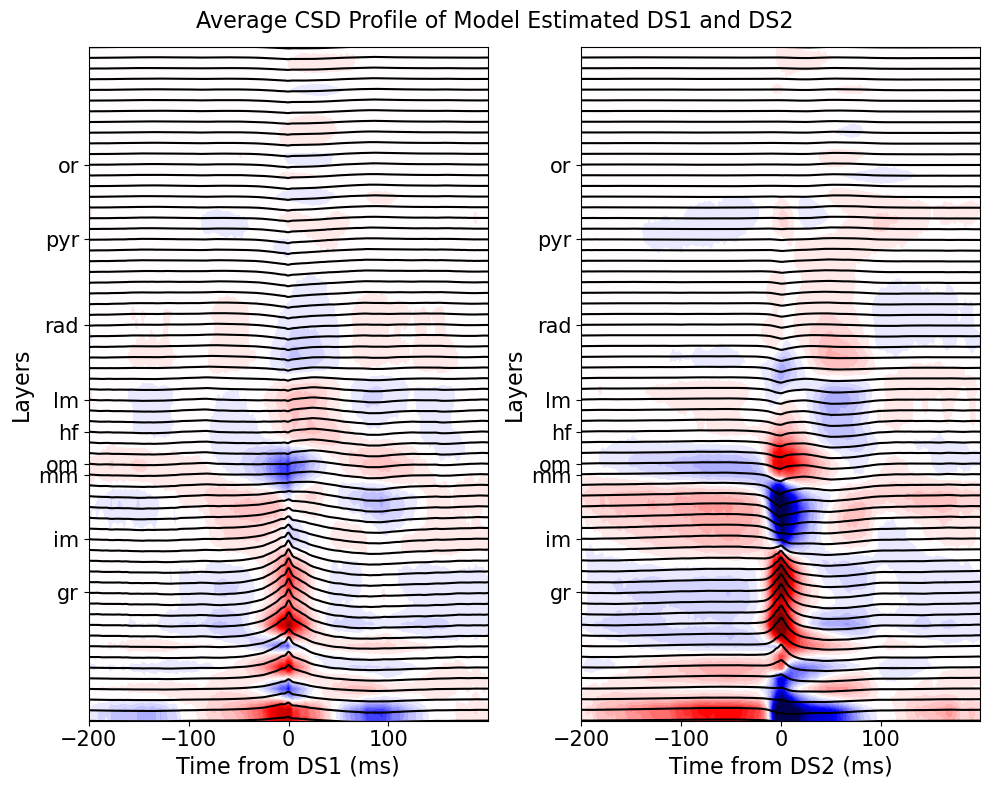

In [173]:
# GET MASK of DS1 and DS2 events
ds1_mask = DSclass_pred == 0
ds2_mask = DSclass_pred == 1

# Set color levels for CSD plot
levels_ = np.linspace(-.15,.15,50)

plt.figure(figsize=(10,8))
# Plot CSD of Triggered Average LFP 
for i,mask in enumerate([ds1_mask,ds2_mask]):
    # Get triggered average LFP of DS1 or DS2 events
    trigAvg_lfp_ds =  lfp_ds[mask].mean(axis=0)
    # Compute CSD 
    csd_ds = CSD.runCSD(trigAvg_lfp_ds)
    
    plt.subplot(1,2,i+1)
    CSD.plotCSD(csd_ds,trigAvg_lfp_ds,dSpikesClassifier.taxis,spacing=1,
                levels_=levels_,
                xlim=None,
                cmap='seismic',
                ax_lbl={'ylabel':'Layers','xlabel':'Time from DS'+str(i+1)+' (ms)'},
                ax=plt.gca())
    mc.probe_yticks(layers)

plt.suptitle('Average CSD Profile of Model Estimated DS1 and DS2',fontsize=16)    
plt.tight_layout()

mc.savefig(resDir+'csd_avg',format_='png')

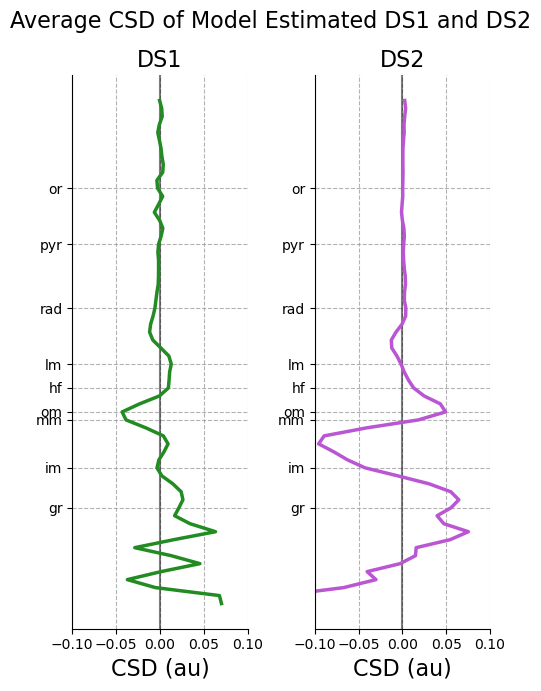

In [158]:
# Now we can also show the mean CSD around 0 
# GET MASK of DS1 and DS2 events
ds1_mask = DSclass_pred == 0
ds2_mask = DSclass_pred == 1

# Get the mean CSD +- 25 ms from dSpike
tmask = np.digitize(dSpikesClassifier.taxis,[-25,25])==1

## PLOT
plt.figure(figsize=(5,7))
# Plot CSD of Triggered Average LFP 
for i,mask in enumerate([ds1_mask,ds2_mask]):
    # Get triggered average LFP of DS1 or DS2 events
    trigAvg_lfp_ds =  lfp_ds[mask].mean(axis=0)
    # Compute CSD 
    csd_ds = CSD.runCSD(trigAvg_lfp_ds)
    
    # Get mean +- 25 ms from dspikes
    csd_ds_signature = csd_ds[:,tmask].mean(axis=-1)
    # Select color of line
    color = 'forestgreen' if i==0 else 'mediumorchid'
    
    # PLOT MEAN CSD 
    plt.subplot(1,2,i+1)
    plt.axvline(0,color='k',lw=1.5,alpha=.5)
    plt.plot(csd_ds_signature,np.arange(len(csd_ds_signature)),lw=2.5,color=color)
    
    plt.xlabel('CSD (au)',fontsize=16)
    plt.title('DS'+str(i+1),fontsize=16)
    
    plt.xlim(-.1,.1)
    plt.gca().invert_yaxis()
    mc.probe_yticks(layers)
    mc.AdjustBoxPlot()

plt.suptitle('Average CSD of Model Estimated DS1 and DS2',fontsize=16)    
plt.tight_layout()

In [169]:
mc.DTT, 100/1250

(0.8, 0.08)